# 09. Splice XRF
This notebook takes data from the reprocessed XRF data exported from the previous notebook and splices it together. There are a total of ~250 core sections. There are two XRF datasets for each core section. One has measurements at a resolution of 2 mm. The other has combined those measurements 10 at a time to make for measurements every 2 cm.

## Setup
### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import shutil
from IPython.display import clear_output

### Set Paths

In [7]:
xrf_processing_path='/Users/danielbabin/GitHub/Green_Bands/Data/U1474/XRF_Processing/'
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'

### Import core depth and identification details
I'll need this information to turn individual core positions from the XRF scanner into total core depths and piece together the splice. 

In [8]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)

## Make Splice

### Retrieve Data from Hardrive
Within this loop, I've also added section identifiers and top and bottom depths for each core. It's easy to do at this step because each dataframe is still only associated with one section. 

In [9]:
cm=pd.read_csv(xrf_processing_path+'2cm-20s.txt',header=2,sep='\t')

In [10]:
results_names=['2mm-2s_'+str(n)+'of8.txt' for n in range(1,9)]

In [12]:
mms={}
for i,file in enumerate(results_names):
    mms[i]=pd.read_csv(xrf_processing_path+file,header=2,sep='\t')

In [13]:
mm=pd.concat([mms[i] for i in mms.keys()],axis=0).reset_index(drop=True)

In [14]:
data={'cm':cm,'mm':mm}

In [15]:
for kind in data.keys():
    if kind=='cm':
        splitn=43
    if kind=='mm':
        splitn=38
    data[kind]['SectionFile']=data[kind]['filename'].str[splitn:]
    data[kind][['SectionLabel','File']]=data[kind]['SectionFile'].str[4:].str.split("-",n=1,expand=True)
    data[kind]['Core']=data[kind]['SectionLabel'].str[:-2]
    data[kind]['Section Top Depth (m CCSF)']=0
    data[kind]['Section Bottom Depth (m CCSF)']=0
    for sect in data[kind]['SectionLabel'].unique():
        data[kind].loc[data[kind]['SectionLabel']==sect,
                       'Section Top Depth (m CCSF)']=section_list[section_list.SectionLabel==
                                                            sect]['Top Depth CCSF (m)'].values[0]
        data[kind].loc[data[kind]['SectionLabel']==sect,
                 'Section Bottom Depth (m CCSF)']=section_list[section_list.SectionLabel==
                                                               sect]['Bottom Depth CCSF (m)'].values[0]

### Turn "Position" from XRF core scanner into CCSF Depth

In [16]:
for kind in data.keys():
    data[kind]['Depth CCSF (m)']=data[kind]['position (mm)']/1000+data[kind]['Section Top Depth (m CCSF)']

### Select the splice

In [17]:
for kind in data.keys():
    for i,core in enumerate(splice.CoreLabel):
        deeper=data[kind].loc[data[kind]['Core']==core,'Depth CCSF (m)']>splice.loc[i,'Top depth CCSF (m)']
        shallower=data[kind].loc[data[kind]['Core']==core,'Depth CCSF (m)']<splice.loc[i,'Bottom depth CCSF (m)']
        data[kind].loc[data[kind]['Core']==core,'In Splice']=deeper&shallower

### Remove outliers
These are section ends where counts are low

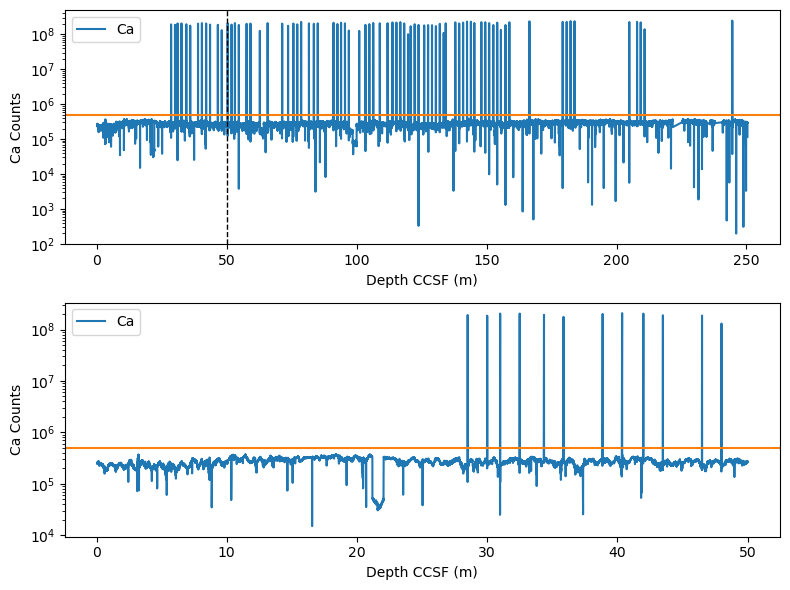

In [18]:
fig,axes=plt.subplots(nrows=2,figsize=(8,6))
data[kind][data[kind]['In Splice']==True].plot(x='Depth CCSF (m)',y='Ca',ax=axes[0])
axes[0].set_yscale('log')
axes[0].axvline(50,color='k',ls='--',lw=1)
axes[0].axhline(5e5,color='tab:orange')
axes[0].set_ylabel('Ca Counts')

data[kind][(data[kind]['In Splice']==True)&(data[kind]['Depth CCSF (m)']<50)].plot(x='Depth CCSF (m)',y='Ca',
                                                                                   ax=axes[1])
axes[1].set_yscale('log')
axes[1].axhline(5e5,color='tab:orange')
axes[1].set_ylabel('Ca Counts')

plt.tight_layout()

In [19]:
for kind in data.keys():
    data[kind]=data[kind][data[kind]['Ca']<5e5].copy()

In [21]:
data['mm']['Fe/Ti']=data['mm']['Fe']/data['mm']['Ti']
data['mm']['ratio']=(data['mm']['Cl']/data['mm']['S'])

In [22]:
data['mm']['inc/coh']=(data['mm']['Cr inc']/data['mm']['Cr coh'])

In [23]:
section='U1474A_3H3'

Text(0, 0.5, 'Sr/Ca')

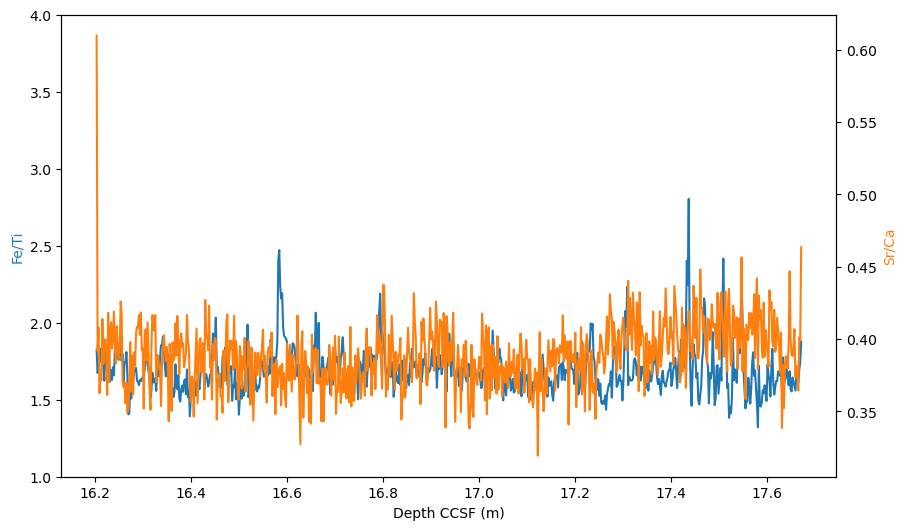

In [24]:
ax=data['mm'].loc[data['mm']['SectionLabel']==
                  section].set_index('Depth CCSF (m)')['Fe/Ti'].plot(figsize=(10,6))
ax.set_ylim(1,4)
sec=data['mm'].loc[data['mm']['SectionLabel']==
                   section].set_index('Depth CCSF (m)')['inc/coh'].plot(secondary_y=True)
# sec.set_ylim(.003,.008)
ax.set_ylabel('Fe/Ti',color='tab:blue')
sec.set_ylabel('Sr/Ca',color='tab:orange')

## Export tables

### Round index

In [25]:
final={}
for kind in data.keys():    
    data[kind]['Depth CCSF (m)']=round(data[kind]['Depth CCSF (m)'].astype(float),3)
    data[kind]=data[kind].sort_values(by='Depth CCSF (m)')
    final[kind]=data[kind].set_index('Depth CCSF (m)',drop=False)

### Clean metadata columns

In [26]:
for kind in data.keys():
    final[kind]['Exp']=361
    final[kind]['Site']=final[kind]['Core'].str[:5]
    final[kind]['Hole']=final[kind]['Core'].str[5]
    final[kind]['Core']=final[kind]['Core'].str.split('_',expand=True)[1]
    final[kind]['Type']=final[kind]['SectionLabel'].str[-2]
    final[kind]['Section']=final[kind]['SectionLabel'].str[-1]
    final[kind]['Top Offset (cm)']=final[kind]['position (mm)']/10

### Pick important columns and order

In [27]:
mm_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section','SectionLabel','Section Top Depth (m CCSF)',
         'Section Bottom Depth (m CCSF)','Top Offset (cm)','filename', 'sample surface', 'validity', 'E-gain',
         'E-offset', 'F-slope', 'F-offset', 'cps', 'MSE',  'Al', 'Si', 'S', 'Cl',
         'Ar', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga',
         'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Rh', 'Pd', 'Cd', 'Sb', 'Ba', 'Ce',
         'Pr', 'Nd', 'Tb', 'Tm', 'Lu', 'Hf', 'Os', 'Ir', 'Pt', 'Hg', 'Tl', 'Pb',
         'Th', 'Pa', 'U', 'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la',
         'W la scat', 'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc',
         'Cr coh', 'Dt', 'In Splice']

In [28]:
cm_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section','SectionLabel','Section Top Depth (m CCSF)',
         'Section Bottom Depth (m CCSF)','Top Offset (cm)','filename', 'sample surface', 'validity', 'E-gain',
         'E-offset', 'F-slope', 'F-offset', 'cps', 'MSE',  'Al', 'Si', 'S', 'Cl',
         'Ar', 'K', 'Ca', 'Ti', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'As',
         'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Rh', 'Pd', 'Cd', 'Sb', 'Ba', 'Ce', 'Pr',
         'Nd', 'Tb', 'Tm', 'Lu', 'Hf', 'Os', 'Ir', 'Pt', 'Hg', 'Tl', 'Pb', 'Th',
         'Pa', 'U', 'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la',
         'W la scat', 'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc',
         'Cr coh', 'Dt', 'In Splice']

In [29]:
cols={'cm':cm_cols,'mm':mm_cols}

In [30]:
for kind in final.keys():
    final[kind]=final[kind][cols[kind]]

### Export

In [32]:
final['mm'].to_csv(table_path+'Supplementary Table X Site U1474 2mm-2s xrf data.csv')
final['cm'].to_csv(table_path+'Supplementary Table X Site U1474 2cm-20s xrf data.csv')